# Baseline Model

In [1]:
#
# Load data and scaler
#

import sys
sys.path.append("..")

from helpers.loaders import load_data, load_scaler

X_train, X_test, y_train, y_test = load_data()
scaler = load_scaler()


In [2]:
#
# Model: Logistic Regression + CalibratedClassifierCV(method="isotonic") 
#

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

base_model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
calibrated_model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
calibrated_model.fit(X_train, y_train)


CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(class_weight='balanced',
                                                    max_iter=1000,
                                                    random_state=42),
                       method='isotonic')

In [3]:
# 
# Predict calibrated probabilities on train and test data
# 

y_train_proba = calibrated_model.predict_proba(X_train)[:, 1] # Predicted probabilities on Train data
y_test_proba = calibrated_model.predict_proba(X_test)[:, 1] # Predicted probabilities on Test data

<br><br>

## Check predictions

In [4]:
# 
# Check some predictions
# 

# samples = 12
# display(X_test.head(samples))
# for i in range(samples):
#     print(f"Predicted stroke risk for index {i}... {y_test_proba[i]*100:.2f}%")


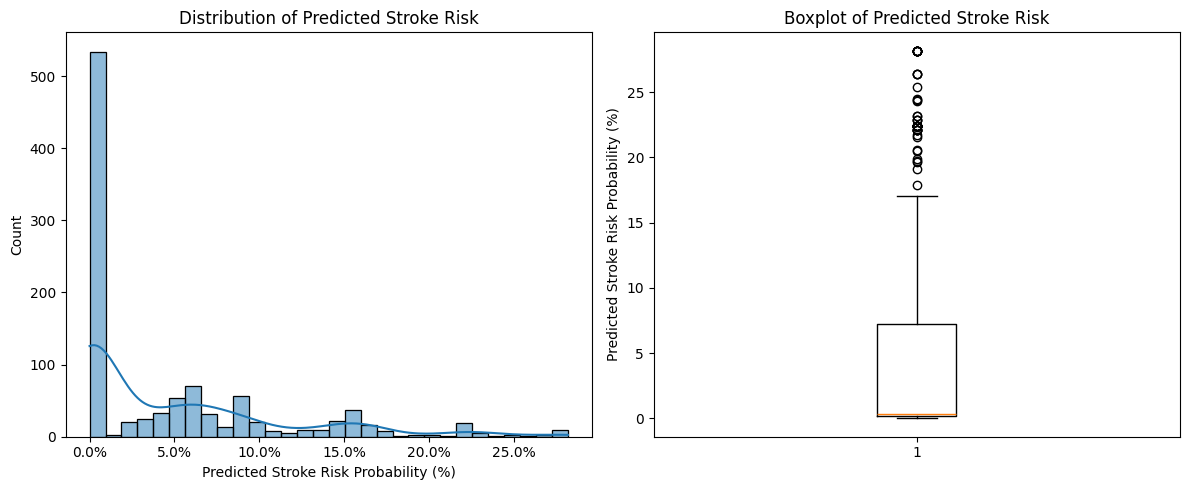

In [5]:
#
# Distribution of predicted probabilities
#

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram + KDE
sns.histplot(y_test_proba, bins=30, kde=True, ax=axes[0])
axes[0].set_xlabel("Predicted Stroke Risk Probability (%)")
axes[0].set_title("Distribution of Predicted Stroke Risk")
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# Boxplot
axes[1].boxplot(y_test_proba * 100)
axes[1].set_ylabel("Predicted Stroke Risk Probability (%)")
axes[1].set_title("Boxplot of Predicted Stroke Risk")

plt.tight_layout()
plt.show()


In [6]:
#
# Probability range
#

print(f"Min predicted risk: {y_test_proba.min():.2f}")
print(f"Max predicted risk: {y_test_proba.max():.2f}")

Min predicted risk: 0.00
Max predicted risk: 0.28


In [7]:
# 
# Average predicted probability
# 

import numpy as np


# Average predicted stroke risk
avg_predicted_risk = y_test_proba.mean()
print(f"\nAverage predicted stroke risk across all test samples: {avg_predicted_risk*100:.2f}% \n")

# Stroke incidence in the original dataset
y_all = np.concatenate([y_train, y_test])
positive_rate = np.mean(y_all) * 100
print(f"Stroke incidence in the original dataset: {positive_rate:.2f}%")



Average predicted stroke risk across all test samples: 4.81% 

Stroke incidence in the original dataset: 4.87%


In [8]:
#
# Note:
# 
# Average predicted stroke risk (~ 5%) is lower than the risk reported in other stroke studies,
# (e.g. https://www.world-stroke.org/world-stroke-day-campaign/about-stroke/impact-of-stroke)
# 
# however, that percentage is in line with the incidence in the dataset used for this analysis (also ~5%)
#

<br>

## Metrics

In [9]:
#
# Brier Score
#

from sklearn.metrics import brier_score_loss

# Train set Brier score
brier_train = brier_score_loss(y_train, y_train_proba)
print(f"Train Brier score: {brier_train:.4f}")

# Test set Brier score
brier_test = brier_score_loss(y_test, y_test_proba)
print(f"Test Brier score: {brier_test:.4f}")


Train Brier score: 0.0426
Test Brier score: 0.0425


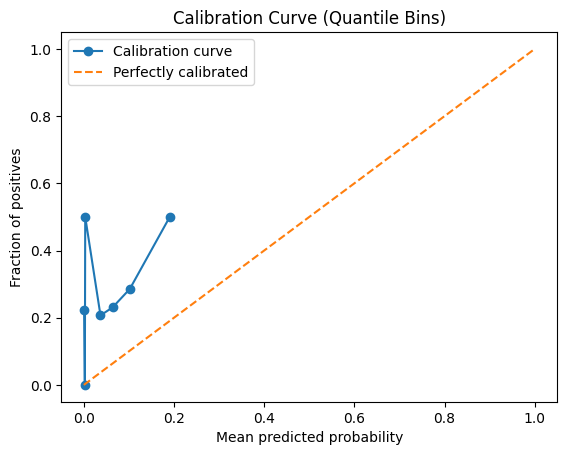

(-0.001, 0.00157]     307
(0.00157, 0.00253]    109
(0.00253, 0.00356]    100
(0.00356, 0.0549]     145
(0.0549, 0.0723]      106
(0.0723, 0.144]       139
(0.144, 0.282]        116
dtype: int64

ECE (Test): 0.2169



In [10]:
#
# Calibration Curve + ECE (Quantile Bins)
#

# Note:
# 
# - using fixed-width bins with calibration_curve(), most predictions cluster in the lower values, leaving some bins with a very low number of predictions (making the calibration curve meaningless in those regions).
# - will use quantile bins to get equal sample size per bin (and a more reliable Calibration Curve & ECE).
# 

import pandas as pd

number_of_bins = 8

y_proba_series = pd.Series(y_test_proba)

# Create quantile bins and retrieve bin edges
bins, bin_edges = pd.qcut(
    y_proba_series,
    q=number_of_bins,
    duplicates='drop',
    retbins=True
)

# Compute mean predicted prob and fraction of positives per bin
bin_avg_pred = y_proba_series.groupby(bins, observed=True).mean()
bin_frac_pos = pd.Series(y_test).groupby(bins, observed=True).mean()
bin_counts = y_proba_series.groupby(bins, observed=True).count()

# Align to ensure same indices
bin_avg_pred, bin_frac_pos = bin_avg_pred.align(bin_frac_pos, join='inner')

# Plot calibration curve
plt.plot(bin_avg_pred, bin_frac_pos, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve (Quantile Bins)')
plt.legend()
plt.show()

# Show bin counts
print(bin_counts)

# Compute ECE
ece = np.sum(
    bin_counts.loc[bin_avg_pred.index] * np.abs(bin_frac_pos - bin_avg_pred)
) / len(y_test_proba)

print(f"\nECE (Test): {ece:.4f}\n")


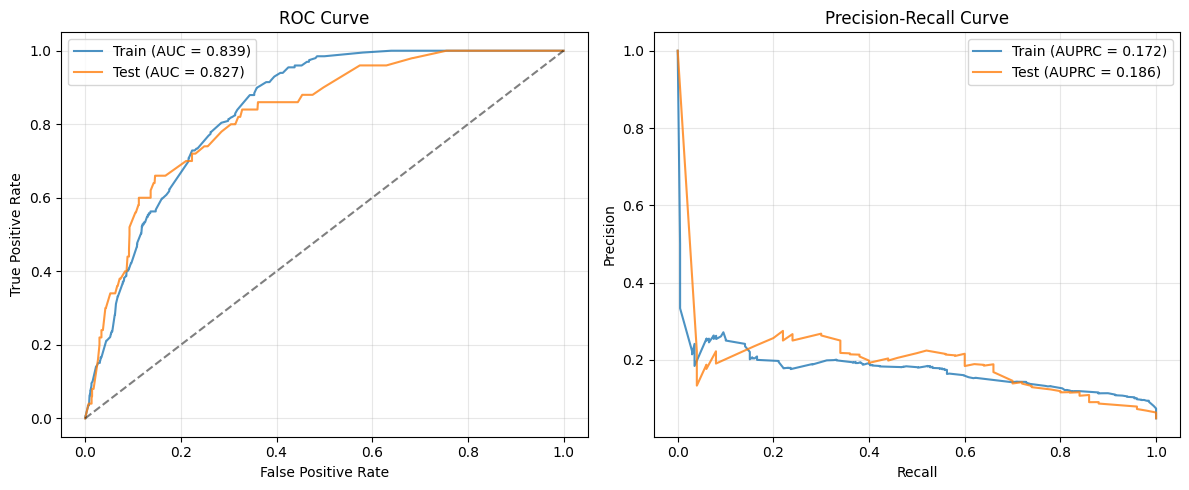

AUC-ROC (Train): 0.8395
AUC-ROC (Test):  0.8269


AUPRC   (Train): 0.1715
AUPRC   (Test):  0.1858


In [11]:
# 
# AUC-ROC + AUPRC
# 

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve


# AUC-ROC Score
auc_roc_train = roc_auc_score(y_train, y_train_proba)
auc_roc_test = roc_auc_score(y_test, y_test_proba)

# AUPRC Score
auprc_train = average_precision_score(y_train, y_train_proba)
auprc_test = average_precision_score(y_test, y_test_proba)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

ax1.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_roc_train:.3f})', alpha=0.8)
ax1.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_roc_test:.3f})', alpha=0.8)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

ax2.plot(recall_train, precision_train, label=f'Train (AUPRC = {auprc_train:.3f})', alpha=0.8)
ax2.plot(recall_test, precision_test, label=f'Test (AUPRC = {auprc_test:.3f})', alpha=0.8)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Display scores
print(f"AUC-ROC (Train): {auc_roc_train:.4f}")
print(f"AUC-ROC (Test):  {auc_roc_test:.4f}")
print("\n")
print(f"AUPRC   (Train): {auprc_train:.4f}")
print(f"AUPRC   (Test):  {auprc_test:.4f}")


## Export model

In [12]:
import pickle

with open("../models/calibrated_baseline.pkl", "wb") as f:
    pickle.dump(calibrated_model, f)